# Fitting polynomials to the Franke Function

This notebook uses `tools.py` to fit a polynomial of degree 5 to the Franke function with OLS, Ridge and Lasso, and analyses the resulting fit using the resampling methods of K-fold-validation and Bootstrap.

We start with some mandatory jupyter magic and imports

In [1]:
%matplotlib  inline
%load_ext autoreload
%autoreload 2

import tools
import plotting
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
from franke import FrankeFunction, FrankePlot

plt.rcParams.update({'font.size': 16})
figure_dir = 'figures/'

Disable this if you don't want to save the plots:

In [2]:
save_fig = True

## The terrain data

In [3]:
from real_data import load_terrain_data, fit_terrain_data, plot_terrain

filename = 'data/n59_e010_1arc_v3.tif'
lambd = 0.01
deg = 5

zpred, data = fit_terrain_data(filename, lambd, deg)
zpred = zpred.reshape(list(reversed(data.shape)))

MSE 9394.4445481
R2 0.452061070723


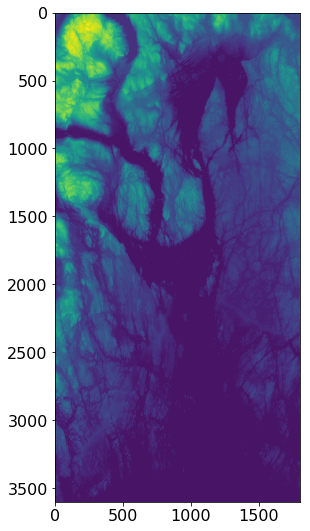

In [12]:
plt.figure(figsize = [16,9])
plt.imshow(data)

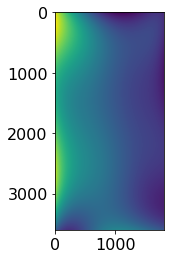

In [5]:
plt.imshow(zpred.T)

In [6]:
# Load the terrain
from imageio import imread

terrain = np.array(imread('data/n59_e010_1arc_v3.tif')).astype(np.float64)
[n,m] = terrain.shape
from scipy.interpolate import interp2d

#def ground_truth_terrain(x_grid,y_grid,patch):
def ground_truth_terrain(patch):
    n_row, n_col= patch.shape
    # interp = interp2d(y_grid,x_grid,patch)
    def terrain_truth(x,y):
        return patch[ (y*n_row).astype(np.int64), (x*n_col).astype(np.int64)]
        # return np.array([a(y_,x_) for x_,y_ in zip(x,y)]) # :(
    return  terrain_truth

# plt.plot(patch[np.ones_like(cols).astype(int), (cols*n_col).astype(int)])

4.91216199683 512.417108826
11.6159962623 1832.56232239


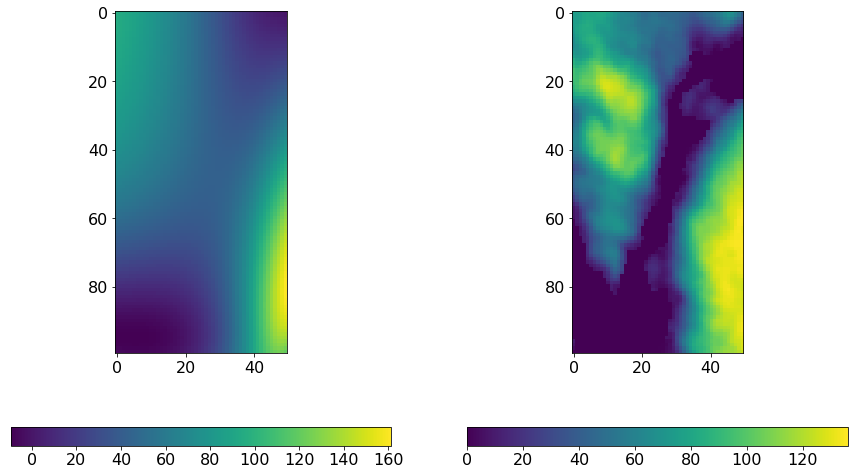

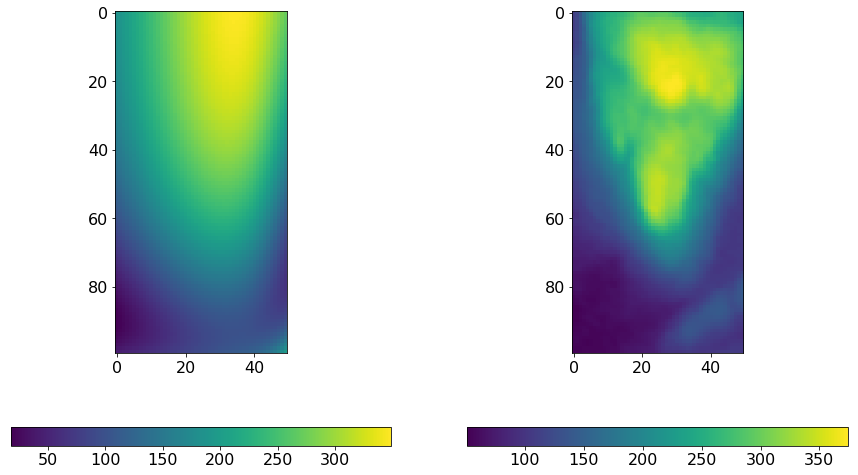

In [7]:
## Find some random patches within the dataset and perform a fit

from sklearn.model_selection import train_test_split

n_row = 100
n_col = 50

# Define their axes
rows = np.arange(0,1,1/n_row)
cols = np.arange(0,1,1/n_col)

[C,R] = np.meshgrid(cols,rows)

x = C.reshape(-1,1).squeeze()
y = R.reshape(-1,1).squeeze()

num_data = n_row*n_col
# Find the start indices of each patch

num_patches = 2
np.random.seed(1)
row_starts = np.random.randint(0,n-n_row,num_patches)
col_starts = np.random.randint(0,m-n_col,num_patches)

for i,row_start, col_start in zip(np.arange(num_patches),row_starts, col_starts):
    row_end = row_start + n_row
    col_end = col_start + n_col

    patch = terrain[row_start:row_end, col_start:col_end]

    z = patch.reshape(-1,1).squeeze()
    
    X = tools.get_X_poly2D(x,y, deg = 12)
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)
    x_train = X_train[:,1]
    y_train = X_train[:,2]
    
    regr = tools.Regression(X_train,z_train, lmbd=10, solve_method = 'svd')
    
    x_mesh = C[row_start:row_end, col_start:col_end]
    y_mesh = R[row_start:row_end, col_start:col_end]
    
    var, bias_sq = tools.get_bias_and_variance(x,y,z,ground_truth = ground_truth_terrain(patch), method='ridge', lmbd=0)
    
    print(var, bias_sq)
    beta_ols = regr.beta

    fitted_patch = regr.predict(X).reshape(n_row, n_col)
    # colormesh_plot(fitted_patch,'Fitted terrain surface',patch)
    fig,[ax1,ax2] = plt.subplots(1,2, figsize = [15,9])
    m1 = ax1.imshow(fitted_patch)
    m2 = ax2.imshow(patch)
    plt.colorbar(m1, ax=ax1, orientation='horizontal')
    plt.colorbar(m2, ax=ax2, orientation='horizontal')


In [13]:
noise = 0.1
seed = 3
lmbd_ridge = 0.005
    
var = defaultdict(list)
bias_sq = defaultdict(list)
degrees = np.arange(5,30, 5)

ground_truth = ground_truth_terrain(patch)
for deg in degrees:
    #clear_output(wait = True)
    print('degree {}'.format(deg))
    v_ols, b_ols = tools.get_bias_and_variance(x,y,z,ground_truth = ground_truth, method = 'ols', lmbd = 0, deg = deg)
    v_rid, b_rid = tools.get_bias_and_variance(x,y,z,ground_truth = ground_truth, method = 'ridge', lmbd = lmbd_ridge ,  deg = deg)
    # var, bias_sq = tools.get_bias_and_variance(x,y,z,, method='ridge', lmbd=0)
    var['ols'].append(v_ols)
    var['ridge'].append(v_rid)
    bias_sq['ols'].append(b_ols)
    bias_sq['ridge'].append(b_rid)
print('Done')

degree 5
degree 10
degree 15
degree 20
degree 25
Done


0.01 0.9
0.01 0.9


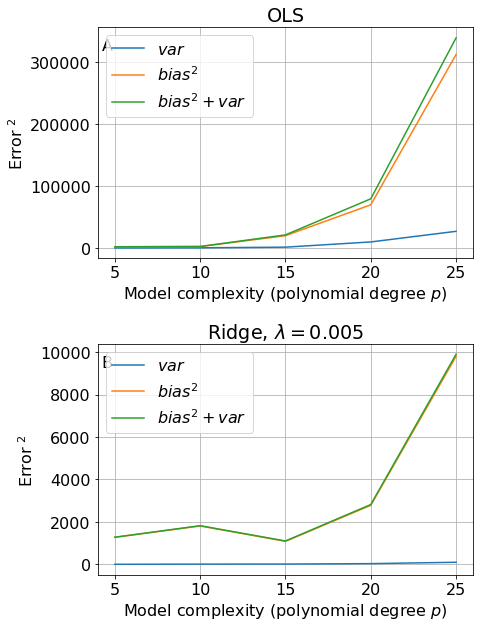

In [14]:
fig,[ax1,ax2] = plt.subplots(2,1, figsize = [7,9], sharex=False)
#fig,ax = plt.subplots(1,1, figsize = [7,9], sharex=False)
# ax1 = ax2 = ax
ax1.set_title('OLS')
ax1.plot(degrees, var['ols'])
ax1.plot(degrees, bias_sq['ols'])
ax1.plot(degrees, np.array(var['ols']) + bias_sq['ols'])

ax2.set_title('Ridge, $\lambda = {}$'.format(lmbd_ridge))
ax2.plot(degrees, var['ridge'])
ax2.plot(degrees, bias_sq['ridge'])
ax2.plot(degrees, np.array(var['ridge']) + bias_sq['ridge'])
for ax in (ax1,ax2):
    ax.set_ylabel('Error $^2$')
    ax.set_xlabel('Model complexity (polynomial degree $p$)')
    ax.legend(['$var$', '$bias^2$ ', '$bias^2 + var$'])
    ax.grid()
fig.tight_layout()
plotting.add_letters_to_axes([ax1,ax2])

# if save_fig:
    # fig.savefig(figure_dir + 'bias_variance.pdf')

In [15]:
[print((k+1)*(k+2)/2) for k in [5,25]]

21.0
351.0


[None, None]

In [362]:
def get_bias_and_variance_terrain(patch, ground_truth=FrankeFunction, method = 'ols', solve_method = 'svd', lmbd = 0, deg = 5):
    """Uses a combination of k-fold (k=50) and bootstrap (50 repetitions)
    to estimate bias and variance. Access to ground truth data, i.e.
    without noise, is necessary."""

    n_row, n_col = patch.shape
    
    row_index = np.arange(n_row)
    col_index = np.arange(n_col)
    rows = np.arange(0,1,1/n_row)
    cols = np.arange(0,1,1/n_col)

    [C,R] = np.meshgrid(cols,rows)

    x = C.reshape(-1,1).squeeze()
    y = R.reshape(-1,1).squeeze()


    def bias_var_return_values(regr, z_test, z_train, design_test, design_train):

        """Specifies the return values in the k_fold-validation as x,y,z_pred"""
        x_train, y_train = design_train[:,2], design_train[:,1]
        x_test, y_test = design_test[:,2], design_test[:,1]
        z_pred = bootstrap_predict_point(x_train, y_train, z_train, 
                x0 = x_test, y0 = y_test, deg = deg, rep = 20, lmbd=lmbd, 
                method = method, solve_method = solve_method)

        return np.array(z_pred), x_test, y_test, z_test

    # k = 50 gives 98% training and 2% test
    ret = k_fold_val(x, y, z,statistic_func=bias_var_return_values, k = 10, deg = deg, method = method,
                           solve_method = solve_method, return_average = False, lmbd = lmbd)

    z_pred = np.concatenate(ret[:,0], axis = 1) 
    x_test = np.concatenate(ret[:,1], axis = 0)
    y_test = np.concatenate(ret[:,2], axis = 0)
    z_test = np.concatenate(ret[:,3], axis = 0)

    z_pred_mean = np.mean(z_pred, axis = 0)
    var = np.mean(np.var(z_pred,axis = 0))
    print(np.mean(z_pred_mean))
    print(ground_truth(x_test,y_test))
    bias_squared = np.mean((ground_truth(x_test,y_test) - z_pred_mean)**2)
    return var, bias_squared, x_test, y_test, z_test, z_pred


In [367]:
# def get_bias_and_variance_terrain(patch, ground_truth=FrankeFunction, 
method = 'ols'
solve_method = 'svd'
lmbd = 0
deg = 5
n_row, n_col = patch.shape

row_index = np.arange(n_row)
col_index = np.arange(n_col)
rows = np.arange(0,1,1/n_row)
cols = np.arange(0,1,1/n_col)

[C,R] = np.meshgrid(cols,rows)

x = C.reshape(-1,1).squeeze()
y = R.reshape(-1,1).squeeze()
z = patch.reshape(-1,1).squeeze()


def bias_var_return_values(regr, z_test, z_train, design_test, design_train):

    """Specifies the return values in the k_fold-validation as x,y,z_pred"""
    x_train, y_train = design_train[:,2], design_train[:,1]
    x_test, y_test = design_test[:,2], design_test[:,1]
    z_pred = tools.bootstrap_predict_point(x_train, y_train, z_train, 
            x0 = x_test, y0 = y_test, deg = deg, rep = 20, lmbd=lmbd, 
            method = method, solve_method = solve_method)

    return np.array(z_pred), x_test, y_test, z_test

# k = 50 gives 98% training and 2% test
ret = tools.k_fold_val(x, y, z,statistic_func=bias_var_return_values, k = 10, deg = deg, method = method,
                       solve_method = solve_method, return_average = False, lmbd = lmbd)

z_pred = np.concatenate(ret[:,0], axis = 1) 
x_test = np.concatenate(ret[:,1], axis = 0)
y_test = np.concatenate(ret[:,2], axis = 0)
z_test = np.concatenate(ret[:,3], axis = 0)

z_pred_mean = np.mean(z_pred, axis = 0)
var = np.mean(np.var(z_pred,axis = 0))
print(np.mean(z_pred_mean))
print(ground_truth(x_test,y_test))
bias_squared = np.mean((ground_truth(x_test,y_test) - z_pred_mean)**2)
# return var, bias_squared, x_test, y_test, z_test, z_pred

209.389773285
[[  77.        ]
 [  75.06568486]
 [  74.6976587 ]
 ..., 
 [ 131.99201321]
 [ 128.73804086]
 [ 127.00171611]]


In [380]:
z_pred_mean = np.mean(z_pred, axis = 0)
var = np.mean(np.var(z_pred,axis = 0))
ground_truth = f

print(np.mean(z_pred_mean))
print(ground_truth(x_test,y_test))
bias_squared = np.mean((ground_truth(x_test,y_test) - z_pred_mean)**2)
var, bias_squared, x_test, y_test, z_test, z_pred

209.389773285
[[  77.        ]
 [  75.06568486]
 [  74.6976587 ]
 ..., 
 [ 131.99201321]
 [ 128.73804086]
 [ 127.00171611]]


(11.041934975297995,
 1899.6470228916337,
 array([ 0.  ,  0.02,  0.04, ...,  0.94,  0.96,  0.98]),
 array([ 0.  ,  0.  ,  0.  , ...,  0.99,  0.99,  0.99]),
 array([ 109.,  120.,  139., ...,  106.,  106.,  105.]),
 array([[ 221.9798304 ,  232.54802037,  241.9523689 , ...,  385.37166624,
          424.20597558,  468.07115664],
        [ 236.3256813 ,  245.7113044 ,  254.07741996, ...,  373.46151776,
          411.74685872,  454.97931665],
        [ 220.22510582,  231.54739045,  241.65302292, ...,  421.76064767,
          466.15022164,  516.21370307],
        ..., 
        [ 269.92766905,  275.94497934,  281.31655084, ...,  360.27679468,
          397.39569728,  439.39710909],
        [ 231.9685289 ,  240.6842206 ,  248.62595476, ...,  405.13045458,
          447.61393868,  495.52263513],
        [ 261.93770549,  268.01934903,  273.48749042, ...,  382.91135764,
          423.09614665,  468.46628108]]))

In [378]:
%matplotlib

Using matplotlib backend: Qt5Agg


In [381]:
ground_truth = ground_truth_terrain(patch)
fig = plt.figure(figsize = [8,4])
ax = fig.gca(projection='3d')
ax.scatter(x_test, y_test, z_test, s=1)
# ax.scatter(x_test, y_test, z_pred_mean, s=1)
ax.scatter(x_test, y_test, ground_truth(y_test,x_test), s=1)
ax.view_init(30,5)

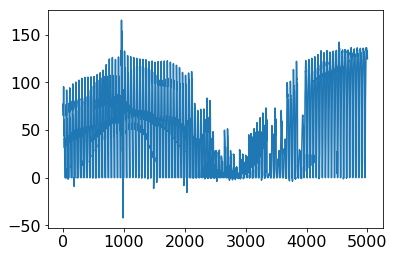

In [348]:

plt.plot(ground_truth(x_test,y_test))

In [259]:
np.sqrt(35672.844782)

188.87256227943752

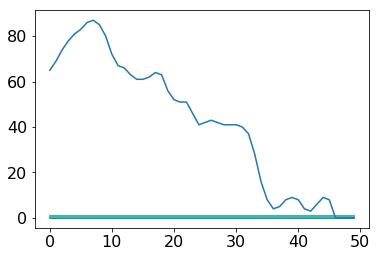

In [239]:

plt.plot(f(x[10*50:11*50],y[10*50:11*50]))
plt.plot(z[10*50:11*50])

In [226]:
C.shape, R.shape, patch.shape

((100, 50), (100, 50), (100, 50))

In [230]:
a = interp2d(x, y, patch)

/home/halvard/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:975: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=64,83 m=5000 fp=419.600042 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [256]:
np.array([a(x_,y_) for x_,y_ in zip(x,y)])

array([[  77.        ],
       [  76.        ],
       [  78.        ],
       ..., 
       [ 117.42831282],
       [ 121.45610982],
       [ 124.67196069]])

In [197]:
# var, np.sqrt(bias_sq)
f = ground_truth_terrain(x_mesh, y_mesh, patch)
plt.figure()
plt.imshow(f(x,y).reshape(patch_size_row,patch_size_col)) 
plt.figure()
plt.imshow(z.reshape(patch_size_row,patch_size_col)) 


/home/halvard/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:975: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=97,55 m=5000 fp=64.862885 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


ValueError: cannot reshape array of size 25000000 into shape (100,50)

In [11]:
# Perform fit over the whole dataset
print("The whole dataset")

rows = np.linspace(0,1,n)
cols = np.linspace(0,1,m)

[C,R] = np.meshgrid(cols,rows)

x = C.reshape(-1,1)
y = R.reshape(-1,1)

num_data = n*m

data = tools.get_X_poly2D(x,y, deg = 5)

z = terrain.flatten()

beta_ols = np.linalg.inv(data.T @ data) @ data.T @ z

fitted_terrain = predict(rows, cols, beta_ols)

mse = np.sum( (fitted_terrain - terrain)**2 )/num_data
R2 = 1 - np.sum( (fitted_terrain - terrain)**2 )/np.sum( (terrain- np.mean(terrain))**2 )
var = np.sum( (fitted_terrain - np.mean(fitted_terrain))**2 )/num_data
bias = np.sum( (terrain - np.mean(fitted_terrain))**2 )/num_data

print("mse: %g\nR2: %g"%(mse, R2))
print("variance: %g"%var)
print("bias: %g\n"%bias)

plt.show()

OSError: No such file: '/home/halvard/uio/fys-stk4155_machinelearning/project1/data/SRTM_data_Norway_1.tif'

ValueError: shape mismatch: objects cannot be broadcast to a single shape

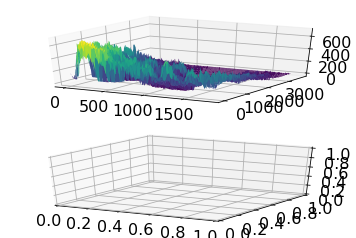

In [18]:
# plot_terrain()
m,n = data.shape

xmesh = np.arange(n)
ymesh = np.arange(m)

[x,y] = np.meshgrid(xmesh, ymesh)


fig = plt.figure()
ax1 = fig.add_subplot(211,projection='3d')
ax2 = fig.add_subplot(212,projection='3d')
ax1.plot_surface(x,y,data,cmap=plt.cm.viridis,linewidth=0)
ax2.plot_surface(x,y,zpred,cmap=plt.cm.viridis,linewidth=0)

# ax = fig.add_subplot(212)
# ax.pcolormesh(x,y,data,cmap=cm.viridis,linewidth=0)
plt.show()


Generating the data is handily provided by `tools.generate_data`, and subsequent model generation is done by creating the design matrix and feeding it to `tools.Regression` for OLS and Ridge regression. $\lambda$ is the penalty in the Ridge regression method, which reduces to OLS if $\lambda = 0$ 